# Rede Neural Convolucional


In [0]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Carregar os datasets

transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train = DataLoader(dataset=dataset_train, shuffle=True, batch_size=200)
test_loader = DataLoader(dataset=dataset_test, shuffle=False, batch_size=1000)
test, validation = [], []

for index, element in enumerate(test_loader):
  if index/len(test_loader) < 0.49:
    test.append(element)
  else:
    validation.append(element)

test_size, validation_size = len(test) * 1000, len(validation) * 1000
print(test_size, validation_size)

5000 5000


In [0]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(3, 64, 2)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, 2)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(self.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, 32*7*7)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

In [6]:
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss().cuda()

print(model)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [0]:
import sys
import copy

def one_hot(results):
    results = results.cpu().detach().numpy().tolist()
    return results.index(max(results))

def train_model(model, epochs, train, test):
    global test_size
    best_model, train_losses, test_acc = model, [], []
    min_error = sys.float_info.max
    
    train_inputs, train_labels = [], []
    for _, (inputs, labels) in enumerate(train):
        train_inputs.append(inputs.to(device))
        train_labels.append(labels.to(device))
    
    test_inputs, test_labels = [], []
    for _, (inputs, labels) in enumerate(test):
        test_inputs.append(inputs.to(device))
        test_labels.append(labels.to(device))
    
    for epoch in range(epochs):
        # Training Set
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(zip(train_inputs, train_labels), 0):
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / (50000/200))
        
        # Test set
        hits = 0
        for i, (inputs, labels) in enumerate(zip(test_inputs, test_labels), 0):
            y_pred = model(inputs)
            for i, (pred, label) in enumerate(zip(y_pred, labels)):
                if one_hot(pred)==label.item():
                    hits+=1
                    
        test_acc.append(hits / test_size * 100)
        if test_acc[-1] <= min_error:
            min_error = test_acc[-1]
            best_model = copy.deepcopy(model)

        print("Loss at epoch ["+ str(epoch + 1) +"]: "+ str(train_losses[-1]) +" (Train Set)")
        print("Accuracy at epoch [" + str(epoch + 1) + "]:"+str(test_acc[-1])+"% (Test Set)")
        print('\n')    
            
    return best_model, train_losses, test_acc

# Trainamento do Modelo


In [8]:
# Treinamento por 400 Épocas
best_model, train_losses, test_acc = train_model(model, 400, train, test)

Loss at epoch [1]: 2.2982462301254274 (Train Set)
Accuracy at epoch [1]:16.580000000000002% (Test Set)


Loss at epoch [2]: 2.2735381841659548 (Train Set)
Accuracy at epoch [2]:20.580000000000002% (Test Set)


Loss at epoch [3]: 2.239522029876709 (Train Set)
Accuracy at epoch [3]:24.16% (Test Set)


Loss at epoch [4]: 2.191661123275757 (Train Set)
Accuracy at epoch [4]:28.02% (Test Set)


Loss at epoch [5]: 2.1426077003479005 (Train Set)
Accuracy at epoch [5]:30.620000000000005% (Test Set)


Loss at epoch [6]: 2.09576078414917 (Train Set)
Accuracy at epoch [6]:32.48% (Test Set)


Loss at epoch [7]: 2.052918100833893 (Train Set)
Accuracy at epoch [7]:33.800000000000004% (Test Set)


Loss at epoch [8]: 2.010741810798645 (Train Set)
Accuracy at epoch [8]:34.96% (Test Set)


Loss at epoch [9]: 1.9676825590133666 (Train Set)
Accuracy at epoch [9]:35.58% (Test Set)


Loss at epoch [10]: 1.9280366883277893 (Train Set)
Accuracy at epoch [10]:36.26% (Test Set)


Loss at epoch [11]: 1.8838817391

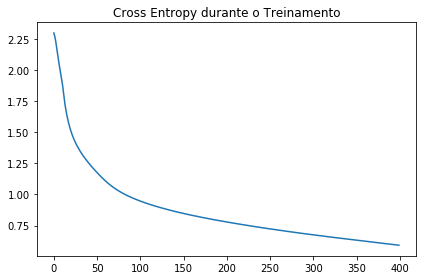

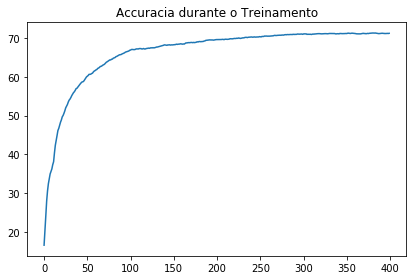

In [9]:
import matplotlib.pyplot as plt
plt.title("Cross Entropy durante o Treinamento")
plt.tight_layout()
_ = plt.plot(train_losses)
plt.show()

plt.title("Accuracia durante o Treinamento")
plt.tight_layout()
_ = plt.plot(test_acc)
plt.show()

In [0]:
def evaluate(model, dataset, batch_size):
  inputs_list, labels_list = [], []
  for _, (inputs, labels) in enumerate(dataset):
      inputs_list.append(inputs.to(device))
      labels_list.append(labels.to(device))
    
  hits = 0
  for i, (inputs, labels) in enumerate(zip(inputs_list, labels_list), 0):
      y_pred = model(inputs)
      for i, (pred, label) in enumerate(zip(y_pred, labels)):
          if one_hot(pred)==label.item():
              hits+=1
  return hits / (len(dataset) * batch_size) * 100

# Avaliação do Modelo no dataset de Treino

In [11]:
print(evaluate(model, train, 200))

79.9


# Avaliação do Modelo no dataset de teste

In [12]:
print(evaluate(model, test, 1000))

71.26


# Validação do Modelo (conjunto de validação)

In [13]:
print(evaluate(model, validation, 1000))

70.6


<p> Nota-se, portanto que foi possível obter bons resultados usando batch norm com convoluções </p>